In [1]:
import pandas as pd
import numpy as np

In [2]:
copy_number = pd.read_csv('OmicsCNGene.csv', index_col=0)
gene_effect = pd.read_csv('CRISPRGeneEffect.csv', index_col=0)

In [53]:
print('Copy Number File....\n')
print(f'Gene Count : {copy_number.shape[1]}')
print(f'Cell Line Count : {copy_number.shape[0]}')

Copy Number File....

Gene Count : 24383
Cell Line Count : 1150


In [54]:
# Check for Nan value
print(f'Nan Value : {copy_number.isna().value_counts().sum()}')

Nan Value : 1150


In [55]:
print('CRISPR Gene Effect File....\n')
print(f'Gene Count : {gene_effect.shape[1]}')
print(f'Cell Line Count : {gene_effect.shape[0]}')

CRISPR Gene Effect File....

Gene Count : 18443
Cell Line Count : 1150


In [56]:
# Check for Nan value
print(f'Nan Value : {gene_effect.isna().value_counts().sum()}')

Nan Value : 1150


# Filter Out X, Y Related Gene
## Data Source:  https://www.gsea-msigdb.org/gsea/msigdb/index.jsp (C1- X, Y)

In [57]:
# List of X, Y Gene
import json
import os 

def load_file(directory):
    '''
    Get File name

    Return:
    json file list
    '''
    json_file = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.json')]

    return json_file

gene_list = []
def get_gene_list(file_names, gene_list):
    '''
    Get Target Gene List

    Return:
    Gene List
    '''
    for idx, name in enumerate(file_names):
        with open(name, 'r') as file:
            data = json.load(file)
            top_key = list(data.keys())[0]
            print(f'Process Number:{idx+1}')
            print(f'Processing File:{top_key}\n')
            gene_symbols = data[top_key]['geneSymbols']
            print(f'Gene Symbol Count:{len(gene_symbols)}')
            print(f'---------------------------------------\n')

            if isinstance(gene_symbols, list):
                gene_list.extend(gene_symbols)
            else:
                gene_list.append(gene_symbols)

    return gene_symbols


In [58]:
# Load X chrom gene symbol
directory = 'X_Chrom'
file_names = load_file(directory)

x_gene_list = get_gene_list(file_names, gene_list)

# Load Y Chrom gene symbol
directory = 'Y_Chrom'
file_names = load_file(directory)

y_gene_list = get_gene_list(file_names, gene_list)

Process Number:1
Processing File:chrXp11

Gene Symbol Count:377
---------------------------------------

Process Number:2
Processing File:chrXp21

Gene Symbol Count:84
---------------------------------------

Process Number:3
Processing File:chrXp22

Gene Symbol Count:250
---------------------------------------

Process Number:4
Processing File:chrXq11

Gene Symbol Count:30
---------------------------------------

Process Number:5
Processing File:chrXq12

Gene Symbol Count:26
---------------------------------------

Process Number:6
Processing File:chrXq13

Gene Symbol Count:165
---------------------------------------

Process Number:7
Processing File:chrXq21

Gene Symbol Count:143
---------------------------------------

Process Number:8
Processing File:chrXq22

Gene Symbol Count:172
---------------------------------------

Process Number:9
Processing File:chrXq23

Gene Symbol Count:89
---------------------------------------

Process Number:10
Processing File:chrXq24

Gene Symbol Coun

In [59]:
# Check Count of X, Y Gene Symbol
print('X Chrom Gene Symbol Count:')
print(len(x_gene_list))
print('\nY Chrom Gene Symbol Count:')
print(len(y_gene_list))

X Chrom Gene Symbol Count:
213

Y Chrom Gene Symbol Count:
12


In [73]:
# Append two gene symbol
target_gene_list = x_gene_list + y_gene_list

In [71]:
def filt_col(data, gene_list):
    '''
    Data Filteration without target list

    Return:
    Filtered DataFrame
    '''
    columns_without_parentheses = [col.split(' (')[0] for col in data.columns]

    filtered_columns = [
        col for col, col_without_paren in zip(data.columns, columns_without_parentheses) 
        if col_without_paren not in gene_list
    ]

    filt_df = data[filtered_columns]

    return filt_df

In [74]:
filt_copy_number = filt_col(copy_number, target_gene_list)
filt_gene_effect = filt_col(gene_effect, target_gene_list)

In [77]:
print(f'After Filteration...\n')
print(f'Copy Number : {copy_number.shape[1]} ---->  {filt_copy_number.shape[1]}')
print(f'Gene Effect : {gene_effect.shape[1]} ---->  {filt_gene_effect.shape[1]}')

After Filteration...

Copy Number : 24383 ---->  24275
Gene Effect : 18443 ---->  18346


In [78]:
common_index = filt_copy_number.index.intersection(filt_gene_effect.index)

print(f'Intersected Cell Line(Count): {len(common_index)}')
copy_number = filt_copy_number.loc[common_index]
gene_effect = filt_gene_effect.loc[common_index]

Intersected Cell Line(Count): 1150


In [79]:
column_counts = []


for column in filt_copy_number.columns:
    #q1 = copy_number[column].quantile(0.25)
    count = ((filt_copy_number[column] >= 0) & (filt_copy_number[column] <= 0.5)).sum() 
    column_counts.append({'Gene': column, 'Count': count})


column_count_df = pd.DataFrame(column_counts)
column_count_df

,Gene,Count
0,FAM87B (400728),17
1,LINC01128 (643837),17
2,AL669831.7 (107984850),17
3,FAM41C (284593),18
4,LINC02593 (100130417),17
...,...,...
24270,RPS4Y2 (140032),689
24271,PRORY (100533178),690
24272,TTTY13 (83868),690
24273,TTTY5 (83863),689


In [80]:
# Sorted by Count 
column_count_df.sort_values(by= 'Count', ascending=False, inplace=True)

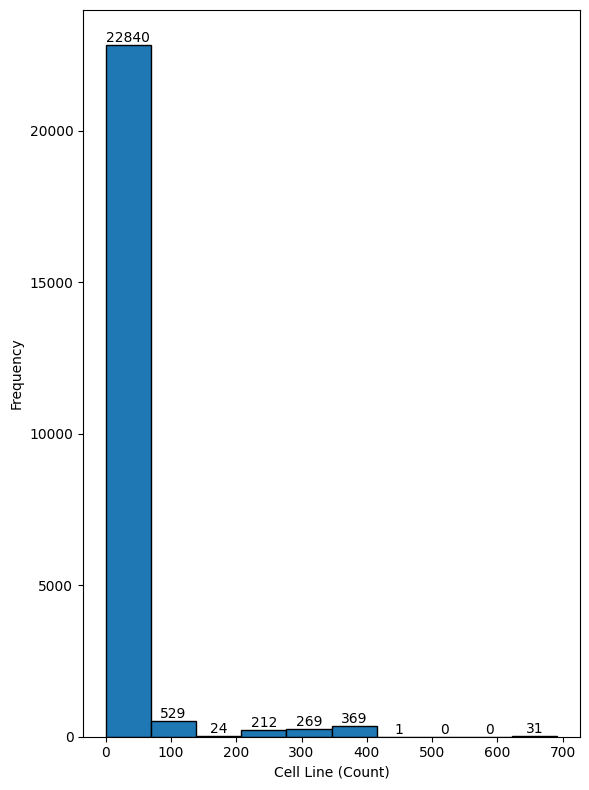

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 8))

counts, bins, patches = plt.hist(column_count_df['Count'], bins=10, edgecolor='black')


for count, bin_left, bin_right in zip(counts, bins[:-1], bins[1:]):
    x = (bin_left + bin_right) / 2  
    y = count  
    plt.text(x, y, f'{int(count)}', ha='center', va='bottom')  


plt.xlabel('Cell Line (Count)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [85]:
# Choose top 50 gene
filtered_genes = column_count_df['Gene'].head(50)
filtered_genes

24274              DAZ3 (57054)
24271         PRORY (100533178)
24263            TTTY14 (83869)
24265           TXLNGY (246126)
24264           BCORP1 (286554)
24272            TTTY13 (83868)
24270           RPS4Y2 (140032)
24268           TTTY10 (246119)
24267    AC010889.2 (105377224)
24266              KDM5D (8284)
24273             TTTY5 (83863)
24269             EIF1AY (9086)
24257              USP9Y (8287)
24259                UTY (7404)
24258              DDX3Y (8653)
24260             TMSB4Y (9087)
24261            NLGN4Y (22829)
24262    NLGN4Y-AS1 (100874056)
24248       TTTY23B (100101121)
24249             TSPY2 (64591)
24250               AMELY (266)
24251             TBL1Y (90665)
24252               PRKY (5616)
24255            TTTY11 (83866)
24253            TTTY12 (83867)
24254           TTTY19 (252952)
24256           TTTY20 (252951)
24247       ZFY-AS1 (107987337)
24246                ZFY (7544)
24245             RPS4Y1 (6192)
24244                SRY (6736)
22577   

In [90]:
# Remove na value by intersected index
filtered_copy_number = filt_copy_number[filtered_genes]
#filtered_copy_number = filtered_copy_number.dropna()

#common_index = gene_effect.index.intersection(filtered_copy_number.index)


#filt_gene_effect = gene_effect.loc[common_index]


In [96]:
from scipy.stats import pearsonr

# Initialize dictionary to store results with correlation > 0.3 and p-value < 0.05
filtered_correlation_results = {}

for copy_col in filtered_copy_number.columns:
    filtered_correlation_results[copy_col] = {}
    
    for effect_col in gene_effect.columns:
        valid_data = pd.concat([gene_effect[effect_col], filtered_copy_number[copy_col]], axis=1)
        valid_data = valid_data.dropna()  # Remove NaN values
        
        if len(valid_data) > 1:
            # Calculate correlation and p-value
            cell_line_count = len(valid_data)
            corr_val, p_val = pearsonr(valid_data.iloc[:, 0], valid_data.iloc[:, 1])
            
            # Filter based on conditions
            if corr_val >= 0.3 and p_val < 0.05:
                filtered_correlation_results[copy_col][effect_col] = {'correlation': corr_val, 'p_value': p_val, 'cell_line': cell_line_count}

# Convert to DataFrame for better visualization
filtered_correlation_df = pd.DataFrame(filtered_correlation_results)

In [98]:
# Target Gene filtering
target_gene = ['BCORP1 (286554)', 'KDM5D (8284)', 'CDKN2A (1029)', 'KDM6A (7403)', 'ASMTL (8623)', 'CSF2RA (1438)', 'SLC25A6 (293)', 'IL3RA (3563)', 'ASMT (438)'
                ,'P2RY8 (286530)', 'AKAP17A (8227)', 'LINC00106 (751580)', 'CRLF2 (64109)', 'PLCXD1 (55344)', 'GTPBP6 (8225)', 'PPP2R3B (28227)', 'CYBB (1536)',
                'DYNLT3 (6990)', 'CASK (8573)']

target_correlation_df = filtered_correlation_df[target_gene]
target_correlation_df.to_excel('target_correlation_df.xlsx')